In [1]:
from utils import *
from model import *
from dataset import *
from train import *
from predict import *

In [2]:
# Open the HDF5 file
import h5py
with h5py.File('/DATA/Shashank/Dataset_Specific_labelled.h5', 'r') as file:
    # List all the groups in the file
    print("Groups in the HDF5 file:")
    for group in file:
        print(group)

    # Get information about a specific dataset
    dataset = file['jet']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    
    dataset = file['Y']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)


    # Explore attributes of the dataset
    print("Dataset attributes:")
    for attr_name, attr_value in dataset.attrs.items():
        print(f"{attr_name}: {attr_value}")

    X = np.array(file['jet'][:])
    Y = np.array(file['Y'][:])
    # Explore more datasets, groups, and attributes as needed


Groups in the HDF5 file:
Y
jet
Dataset shape: (10000, 125, 125, 8)
Dataset dtype: float32
Dataset shape: (10000, 1)
Dataset dtype: float32
Dataset attributes:


In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [4]:
dataset = Custom_Dataset(X, Y, transform,mode = 'train')

In [5]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [6]:
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)

# If pretraining is peformed before load pretrained weights
model = torch.load('/DATA/Shashank/GSOC 2024/Masked_Autoencoder/Masked_Autoencoder/model.pth')

In [7]:
# Instanitate Classifier
encoder = model.encoder
classifier = VIT_classifier(encoder, 2)

In [8]:
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    classifier = nn.DataParallel(classifier)
classifier = classifier.to('cuda')

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
training_loss = []
validation_loss = []
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
trainer = CustomTrainer(classifier, train_dataloader, val_dataloader)

In [11]:
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train(epochs = 1, save_path =  '/DATA/Shashank/best_model.pth'
)

Epoch 1/1 - Validation: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Epoch 1/1, Train Loss: 0.6925, Train Accuracy: 0.5130, Valid Loss: 0.6896, Valid Accuracy: 0.5117


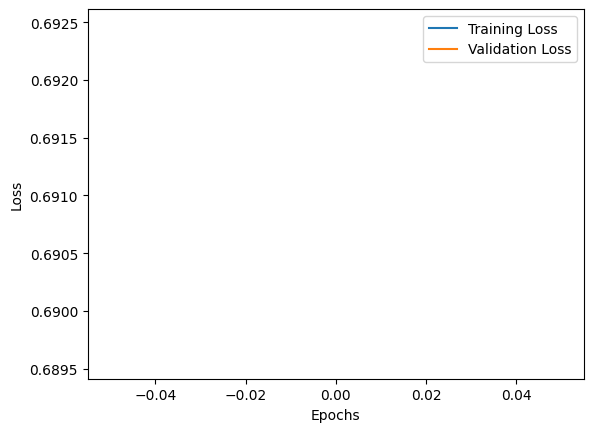

In [12]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()